In [1]:
from datasets import load_dataset
imdb_dataset = load_dataset("stanfordnlp/imdb", name="plain_text")

e:\miniconda3\envs\cs224\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
e:\miniconda3\envs\cs224\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
import re

NUM_SAMPLES = 1000
START_TOKEN = '<START>'
END_TOKEN = '<END>'

def read_corpus():
    """ Read files from the Large Movie Review Dataset.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = imdb_dataset["train"]["text"][:NUM_SAMPLES]
    return [[START_TOKEN] + [re.sub(r'[^\w]', '', w.lower()) for w in f.split(" ")] + [END_TOKEN] for f in files]

In [10]:
from pprint import pprint

imdb_corpus = read_corpus()
pprint(imdb_corpus[:3], compact=True, width=100)

[['<START>', 'i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because',
  'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first',
  'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized',
  'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore',
  'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to',
  'see', 'this', 'for', 'myselfbr', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young',
  'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything',
  'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her',
  'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average',
  'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam',
  'war', 'and', 'race', 'issu

### 1. Window based Co-occurence matrix:

In [58]:
window_size = 8

def build_vocab(corpus):
    vocab = set()
    for sentence in corpus:
        for word in sentence:
            vocab.add(word)

    vocab = sorted(list(vocab))

    word2ind = {word:idx for idx, word in enumerate(vocab)}
    ind2word = {idx:word for idx, word in enumerate(vocab)}

    return word2ind, ind2word

def compute_co_occurrence_matrix(corpus, window_size=1):
    import numpy as np
    word2ind, ind2word = build_vocab(corpus)
    vocab_size = len(word2ind.items())

    M = np.zeros((vocab_size, vocab_size))

    for sentence in corpus:
        sentence_length = len(sentence)
        for i, word in enumerate(sentence):
            word_idx = word2ind.get(word, None)
            if word_idx is None:
                continue
            start = max(0, i - window_size)
            end = min(sentence_length, i + window_size + 1)
            for j in range(start, end):
                if j != i:
                    context_word = sentence[j]
                    context_word_idx = word2ind.get(context_word, None)
                    if context_word_idx is not None:
                        M[word_idx, context_word_idx] += 1

    return M

M = compute_co_occurrence_matrix(imdb_corpus, window_size)

In [60]:
from sklearn.decomposition import TruncatedSVD

truncated_svd = TruncatedSVD(n_components=2)
U = truncated_svd.fit_transform(M)

In [50]:
def plot_embeddings(M_reduced, word2ind, words):
    import matplotlib.pyplot as plt

    for word in words:
        word_idx = word2ind.get(word, None)
        x_coord = M_reduced[word_idx, 0]
        y_coord = M_reduced[word_idx, 1]
        plt.scatter(x_coord, y_coord, marker='x', color='red')
        plt.text(x_coord+0.005, y_coord+0.005, word, fontsize=9)
    plt.show()

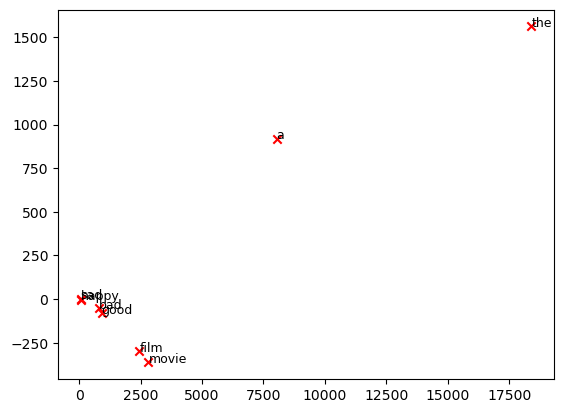

In [61]:
word2ind, ind2word = build_vocab(imdb_corpus)
words = ['the', 'a', 'good', 'bad', 'movie', 'film', 'happy', 'sad']
plot_embeddings(U, word2ind, words)

### 2. CBOW